# Generating Music with LSTM

### Installing necessary libraries used for processing MIDI files

In [1]:
!sudo apt install -y fluidsynth

In [2]:
!pip install --upgrade pyfluidsynth

In [3]:
!pip install pretty_midi

In [4]:
!pip install wandb

In [5]:
!unzip archive.zip -d source_music

### Used libraries

In [ ]:
import collections
import datetime
import fluidsynth
import glob
import numpy as np
import pathlib
import pandas as pd
import pretty_midi
import seaborn as sns
import tensorflow as tf
import wandb
import random
import math

from IPython import display
from matplotlib import pyplot as plt
from typing import Optional
from collections import Counter
from wandb.keras import WandbCallback
from tensorflow.keras import backend as K

### Wandb init

In [6]:
wandb.login()
wandb.init()
config = wandb.config

### Seed and sampling rate (used for notes)

In [ ]:
seed = 1
tf.random.set_seed(seed)
np.random.seed(seed)

SAMPLING_RATE = 16000

### Paths to all files

In [ ]:
FILE = "source_music/"
data_dir = pathlib.Path(FILE)
filenames = glob.glob(str(data_dir/'**/*.mid*'))

### Processing files and extracting instruments

In [ ]:
instruments = []

for file in filenames:
  file_pm = pretty_midi.PrettyMIDI(file)
  for instrument in file_pm.instruments:
    instrument_name = pretty_midi.program_to_instrument_name(instrument.program)
    instruments.append(instrument_name)

print(Counter(instruments).keys())
print(Counter(instruments).values())

dict_keys(['Acoustic Grand Piano', 'Bright Acoustic Piano'])
dict_values([589, 27])


### Most common instrument

In [ ]:
instrument_name = 'Acoustic Grand Piano'

### Transfering midi file to notes

It is necessary to transfer midi file to notes to be able to make the data trainable. For the note representation, `pitch` and `duration` were extracted. To represent the relation between previous and next note, parameter `step` was also extracted.

The commented code below represents suggested improvement which, on the contrary, worsened the result so it was not used.
 The solution consisted of repeating song to fill the length of the longest song to create batches that will not blend different songs. 

In [ ]:
def midis_to_notes(midi_files):

  all_notes = collections.defaultdict(list)

  sorted_notes_all = []

  #max_length = 0

  for file in midi_files:
    file_pm = pretty_midi.PrettyMIDI(file)
    instrument = file_pm.instruments[0]

    sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
    sorted_notes_all.append(sorted_notes)

    #current_length = len(sorted_notes)

    #if current_length > max_length:
    #  max_length = current_length

  random.shuffle(sorted_notes_all)

  #print(max_length)

  for notes in sorted_notes_all:
    #tempList = list(notes)
    #for i in range(math.ceil(max_length/len(notes))):
    #  for element in tempList:
    #    if len(notes) == max_length:
    #      break
    #    notes.append(element)
    prev_start = notes[0].start

    for note in notes:
      start = note.start
      end = note.end
      all_notes['pitch'].append(note.pitch)
      all_notes['step'].append(max(0, start - prev_start))
      all_notes['duration'].append(max(0, end - start))
      all_notes['start'].append(start)
      all_notes['end'].append(end)
      prev_start = start

  return pd.DataFrame({name: np.array(value) for name, value in all_notes.items()})

In [ ]:
notes = midis_to_notes(filenames)
notes.head()

378970


In [ ]:
print("There are " + str(len(notes.index)) + " notes in " + str(len(filenames)) + " MIDI files")

There are 378970 notes in 292 MIDI files


### Function for plotting notes

In [ ]:
def plot_piano_roll(notes, min = None, max = None):
  if not max or min >= max:
    max = len(notes['pitch'])
    min = 0
    
  plt.figure(figsize=(20, 4))
  pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
  start_stop = np.stack([notes['start'], notes['end']], axis=0)
  plt.plot(
      start_stop[:, min:max], pitch[:, min:max], color="r", marker=".")
  plt.xlabel('time')
  plt.ylabel('pitch')
  _ = plt.title("Note continuity")

### First 1000 notes from our dataset

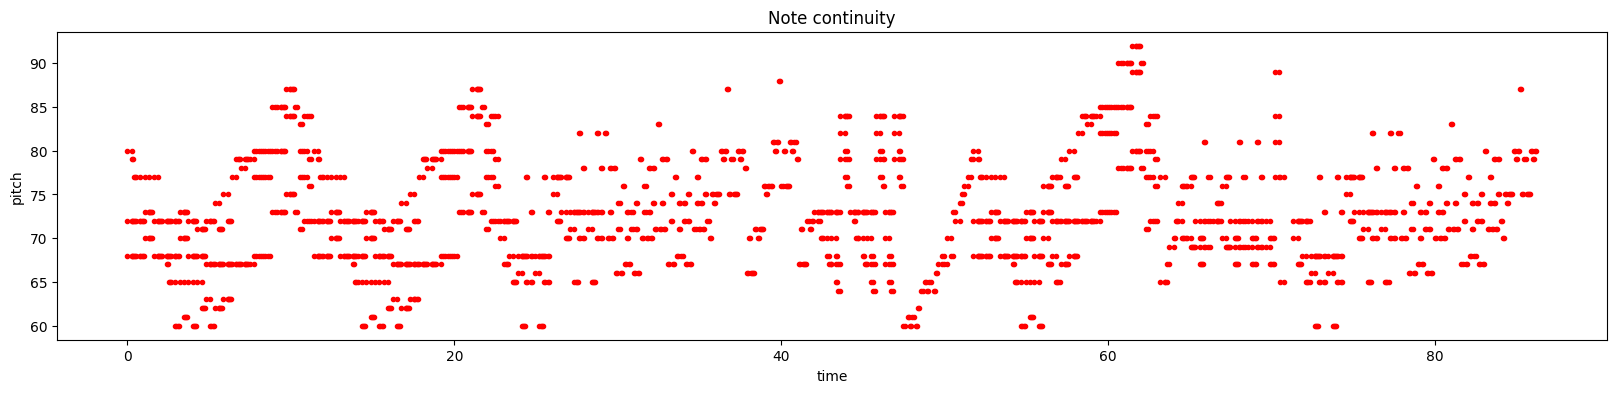

In [ ]:
plot_piano_roll(notes, 0, 1000)

### Histplot of our features

We can see that pitch values are normally distributed. On the other hand step and duration is mostly around 0, which is expected.

<Axes: xlabel='duration', ylabel='Density'>

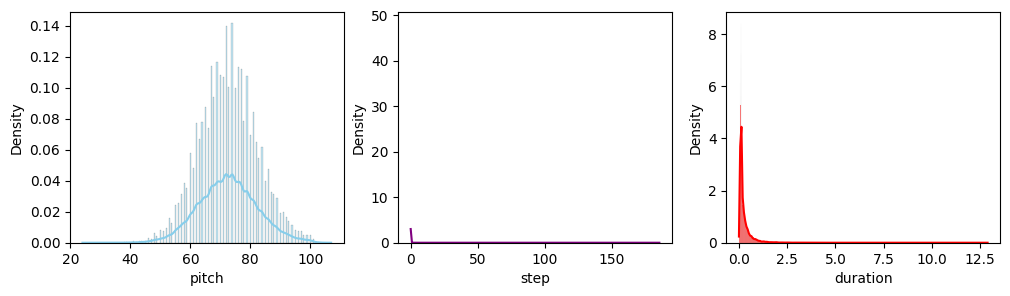

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))

sns.histplot(data=notes["pitch"], stat="density", kde=True, color="skyblue", ax=axs[0])
sns.histplot(data=notes["step"], stat="density", kde=True, color="purple", ax=axs[1])
sns.histplot(data=notes["duration"], stat="density", kde=True, color="red", ax=axs[2])


### Create dataset object from our data

In [ ]:
key_order = ['pitch', 'step', 'duration']
train_notes = np.stack([notes[key] for key in key_order], axis=1)

In [ ]:
notes_train_dataset = tf.data.Dataset.from_tensor_slices(train_notes)

### Training settings

SEQ_LENGTH represents sequence length of notes that are an input for LSTM to predict following note.

In [ ]:
SEQ_LENGTH = 32
VOCAB_SIZE = 128
config.SEQ_LENGTH = SEQ_LENGTH
config.VOCAB_SIZE = VOCAB_SIZE

### Dataset transform to sequences

In [ ]:
new_seq_length = config.SEQ_LENGTH+1
windows = notes_train_dataset.window(new_seq_length, shift=1, stride=1, drop_remainder=True)

def flatten_dataset(x):
    return x.batch(new_seq_length, drop_remainder=True)

sequences_final = windows.flat_map(flatten_dataset)

def prepare_dataset(all_sequences):
    input_sequences = all_sequences[:-1]
    output_sequence = all_sequences[-1]

    labels = {}
    for i in range(len(key_order)):
      labels[key_order[i]] = output_sequence[i]

    return input_sequences/[config.VOCAB_SIZE,1.0,1.0], labels

seq_dataset = sequences_final.map(prepare_dataset) 


### Batch size and shuffle of sequences

In [ ]:
batch_size = 256
buffer_size = len(notes) - config.SEQ_LENGTH
notes_train_dataset = (seq_dataset.shuffle(buffer_size).batch(batch_size, drop_remainder=True).cache().prefetch(tf.data.experimental.AUTOTUNE))

### Custome loss function

Since duration and step are always positive we add a penalty to classic MAE (Mean Absolute Error) for negative predicted values to accomplish better results when training.

In [ ]:
def custom_mae(y_true, y_pred):
    diff = K.abs(y_pred - y_true)

    penalty = K.maximum(0.0, -y_pred)

    weighted_diff = diff + 2 * penalty

    mean_weighted_diff = K.mean(weighted_diff)

    return mean_weighted_diff

### Model structure

We used a single layer of LSTM with 3 outputs that represent our features (new note generating). For duration and step we use our previously mentioned custom loss function and for pitch we use SparseCategoricalCrossentropy (We handle Pitch as classification). We weigthed the outputs because pitch had much larger loss than other features (We optimize the combined loss only). 

We experimented with multiple version of models and mostly focused on trying different learning_rate, units of LSTM, droupout values, sequence length, batch size. We also tried using multiple LSTM layers, but we did not achieve better results.

In [ ]:
LEARNING_RATE = 0.005

inputs = tf.keras.Input((config.SEQ_LENGTH, 3))
x = tf.keras.layers.LSTM(256, dropout = 0.1, recurrent_dropout = 0.1)(inputs)

outputs = {
  'pitch': tf.keras.layers.Dense(128, name='pitch')(x),
  'step': tf.keras.layers.Dense(1, name='step')(x),
  'duration': tf.keras.layers.Dense(1, name='duration')(x),
}

losses = {
      'pitch': tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
      'step': custom_mae,
      'duration': custom_mae
}

loss_weights={
        'pitch': 0.04,
        'step': 1.0,
        'duration':1.0,
}

model = tf.keras.Model(inputs, outputs)

model.compile(loss=losses, optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE), loss_weights=loss_weights)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 3)]      0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 256)          266240      ['input_1[0][0]']                
                                                                                                  
 duration (Dense)               (None, 1)            257         ['lstm[0][0]']                   
                                                                                                  
 pitch (Dense)                  (None, 128)          32896       ['lstm[0][0]']                   
                                                                                              

### Callbacks (Checkpoint, EarlyStopping and wandb)

In [ ]:
def get_callbacks(patience, checkpoint_filepath):
  checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='checkpoint_filepath', save_weights_only=True)

  es = tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=patience,
        verbose=1,
        restore_best_weights=True)
  
  wandb = WandbCallback()
  
  return [wandb, checkpoint, es]

### Training and EarlyStopping parameters

In [ ]:
MAX_EPOCHS = 250
PATIENCE = 5
checkpoint_filepath = "checkpoints/checkpoint_weights"

history = model.fit(notes_train_dataset, epochs=MAX_EPOCHS, callbacks=get_callbacks(PATIENCE, checkpoint_filepath))

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/250
    419/Unknown - 70s 49ms/step - loss: 0.4138 - duration_loss: 0.1278 - pitch_loss: 3.7447 - step_loss: 0.1362

In [ ]:
wandb.finish()

In [ ]:
def squeeze_item(item):
    return tf.squeeze(item, axis=-1)

### Function for generating Note

In [ ]:
def predict_next_note(notes, keras_model, temperature):

  inputs = tf.expand_dims(notes, 0)

  prediction_all = model.predict(inputs)
  pitch = tf.random.categorical(prediction_all['pitch']/temperature, num_samples=1)
  step = prediction_all['step']
  duration = prediction_all['duration']

  pitch = int(squeeze_item(pitch))
  duration = squeeze_item(duration)
  step = squeeze_item(step)

  step = float(tf.maximum(0, step))
  duration = float(tf.maximum(0, duration))

  return pitch, step, duration

### Generating song

TEMPERATURE represents randomness of pitch values.

In [ ]:
TEMPERATURE = 1.5
NUM_OF_PRED = 150

In [ ]:
values = [notes[key] for key in key_order]
sample_notes = np.stack(values, axis=1)

random_number = random.randint(0, len(sample_notes) - SEQ_LENGTH - 1)

input_notes = (sample_notes[random_number:random_number + SEQ_LENGTH] / np.array([VOCAB_SIZE, 1, 1]))

generated_notes = []
start_old = 0
for _ in range(NUM_OF_PRED):
  pitch, step, duration = predict_next_note(input_notes, model, TEMPERATURE)
  
  start = start_old + step
  end = start + duration
  input_note = (pitch, step, duration)

  generated_notes.append((*input_note, start, end))
  input_notes = np.delete(input_notes, 0, axis=0)
  input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
  start_old = start

generated_notes = pd.DataFrame(generated_notes, columns=(*key_order, 'start', 'end'))

### Notes to midi file and PrettyMidi for player

In [ ]:
def notes_to_midi(notes, out_file, instrument_name, velocity = 100):

  pm = pretty_midi.PrettyMIDI()
  instrument = pretty_midi.Instrument(program=pretty_midi.instrument_name_to_program(instrument_name))

  prev_start = 0
  for i, note in notes.iterrows():
    start = float(prev_start + note['step'])
    end = float(start + note['duration'])
    note = pretty_midi.Note(velocity=velocity, pitch=int(note['pitch']), start=start, end=end,)
    instrument.notes.append(note)
    prev_start = start

  pm.instruments.append(instrument)
  pm.write(out_file)
  return pm

### Function for generating midi player

In [ ]:
def play_midi(pm, seconds=60):
  full_synth = pm.fluidsynth(fs=SAMPLING_RATE)

  shortened_synth = full_synth[:seconds*SAMPLING_RATE]
  return display.Audio(shortened_synth, rate=SAMPLING_RATE)

### Plot of generated song

In [ ]:
plot_piano_roll(generated_notes, 0, NUM_OF_PRED)

### Converting the notes to the final result

Notes are conversed to midi file, midi file is printed out and saved to `generated_song.midi`.

In [ ]:
generated_file = 'generated_song.midi'
generated_pm = notes_to_midi(generated_notes, out_file=generated_file, instrument_name=instrument_name)
play_midi(generated_pm, seconds=60)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=7c918863-8f84-4adc-ade8-b4cb5a6a15d9' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>